In [1]:
!pip install scikeras
!pip install keras_tuner
!pip install tensorflow_io

In [2]:
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import shutil
import random
import time
import importlib
import sklearn

in_colab = "google.colab" in sys.modules
if in_colab:
    if not os.getcwd().split("/")[-1].split("_")[-1] == "2023":
        from google.colab import drive

        drive.mount("/content/drive")
        os.chdir(r"/content/drive/MyDrive/Human_Data_Analytics_Project_2023")


main_dir = os.getcwd()
print(main_dir)


importlib.reload(importlib.import_module("Visualization.model_plot"))
from Visualization.model_plot import *
from tensorflow.keras.models import save_model  # from labs
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import (
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from sklearn.metrics import precision_recall_fscore_support, auc
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt

import random
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
import os
import librosa
import scikeras


if main_dir not in sys.path:
    print("Adding the folder for the modules")
    sys.path.append(main_dir)

from Preprocessing.data_loader import load_metadata

df_ESC10, df_ESC50 = load_metadata(
    main_dir, heads=False, ESC_US=False, statistics=False
)


from Models.ann_utils import *
from tensorflow.python.ops.gen_array_ops import broadcast_to_eager_fallback

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Human_Data_Analytics_Project_2023
Adding the folder for the modules


# Some ideas for data augmentation

In [3]:
ind = random.randint(0, np.max(np.shape(df_ESC50)))
path1 = df_ESC50.full_path[ind]
audio, sample_rate = librosa.load(path1, sr=44100)
print(f"Category: {df_ESC50.category[ind]}\n")
display(ipd.Audio(data=audio, rate=sample_rate))

Category: hen



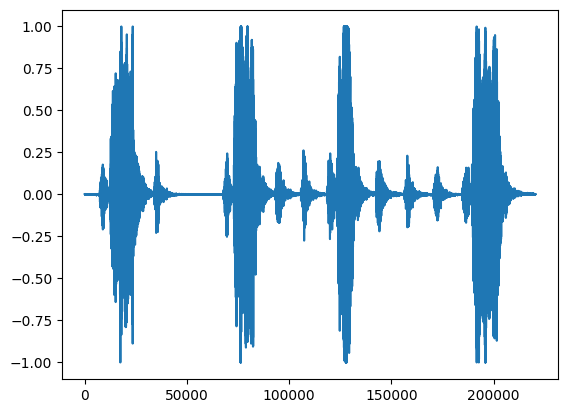

In [4]:
plt.plot(audio)

In [5]:
print("Use tfio.audio.trim")
position = tfio.audio.trim(
    audio, axis=0, epsilon=0.1
)  # Returns a tensor of start and stop with shape [..., 2, ...].
print(f"The positions are {position}")

Use tfio.audio.trim
The positions are [  8104 206228]


In [6]:
start = position[0]
stop = position[1]
print(start, stop)

tf.Tensor(8104, shape=(), dtype=int64) tf.Tensor(206228, shape=(), dtype=int64)


In [7]:
processed = audio[
    start:stop
]  # we cannot modify thew shape of our  input...discard this method

In [8]:
processed.shape

(198124,)

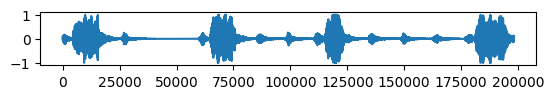

In [9]:
plt.subplot(6, 1, 2)
plt.plot(processed)

In [10]:
fade = tfio.audio.fade(audio, fade_in=100000, fade_out=200000, mode="logarithmic")

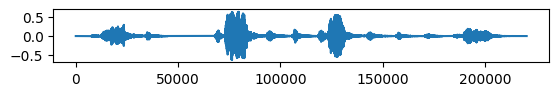

In [11]:
plt.subplot(6, 1, 3)
plt.plot(fade.numpy())
display(ipd.Audio(data=fade.numpy(), rate=sample_rate))

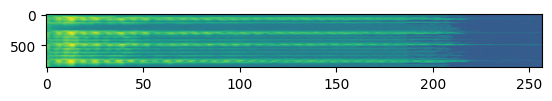

In [12]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=256)

plt.subplot(6, 1, 4)
plt.imshow(tf.math.log(spectrogram).numpy(), aspect="auto")

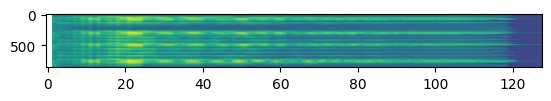

In [13]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000
)


plt.subplot(6, 1, 5)
plt.imshow(tf.math.log(mel_spectrogram).numpy(), aspect="auto")

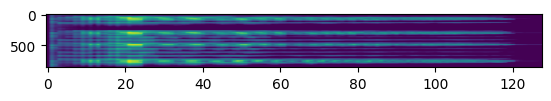

In [14]:
# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

plt.subplot(6, 1, 6)
plt.imshow(dbscale_mel_spectrogram.numpy(), aspect="auto")

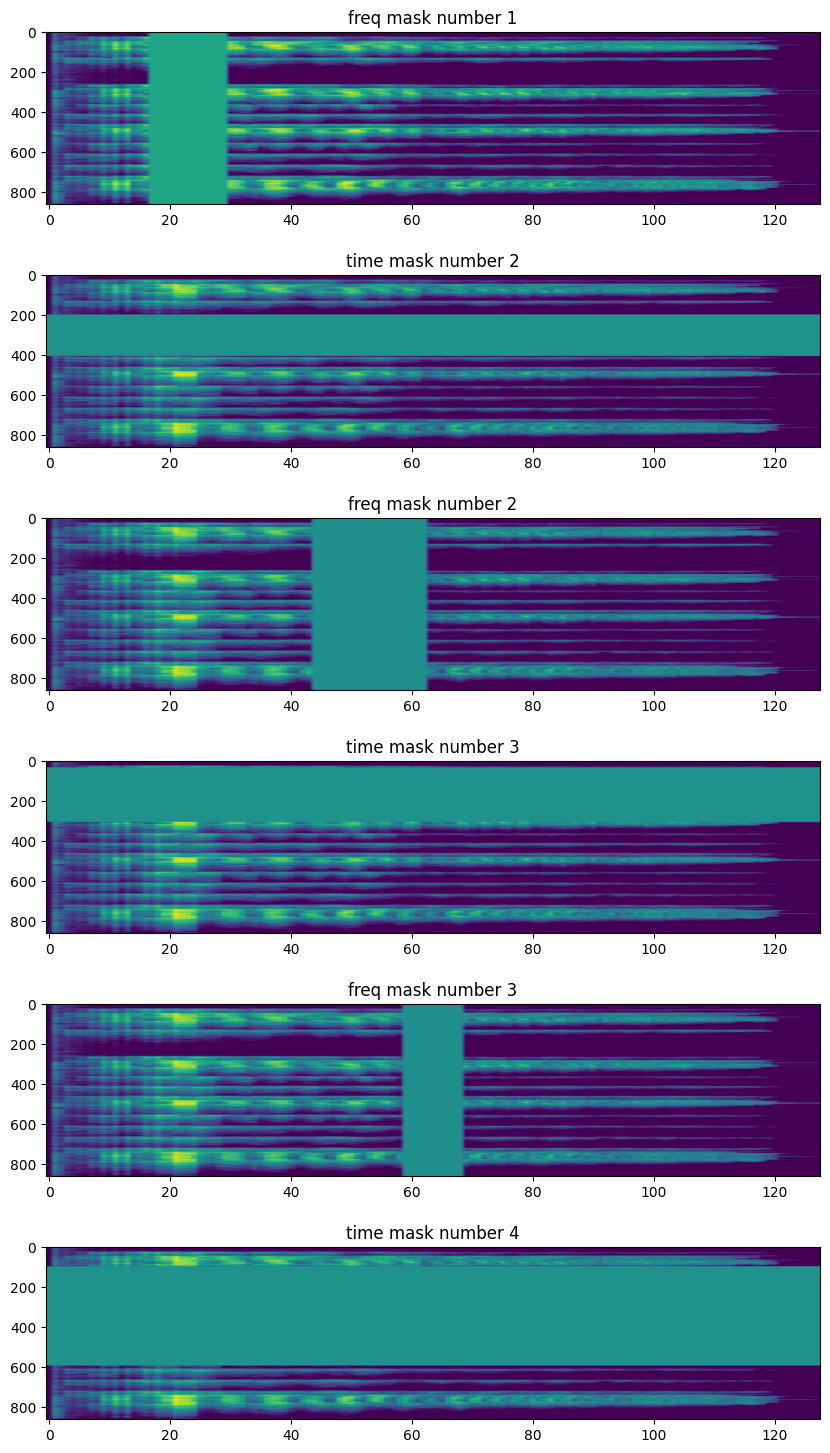

In [15]:
plt.subplots(6, 1, figsize=(9, 15))
plt.tight_layout(pad=3)
for i in range(3):
    # Freq masking
    freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=20)

    plt.subplot(6, 1, 2 * i + 1)
    plt.title(f"freq mask number {i+1}")
    plt.imshow(freq_mask.numpy(), aspect="auto")

    # Time masking
    time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=500)

    plt.subplot(6, 1, 2 * i + 2)
    plt.title(f"time mask number {i+2}")
    plt.imshow(time_mask.numpy(), aspect="auto")

(400000,)
(220500,)


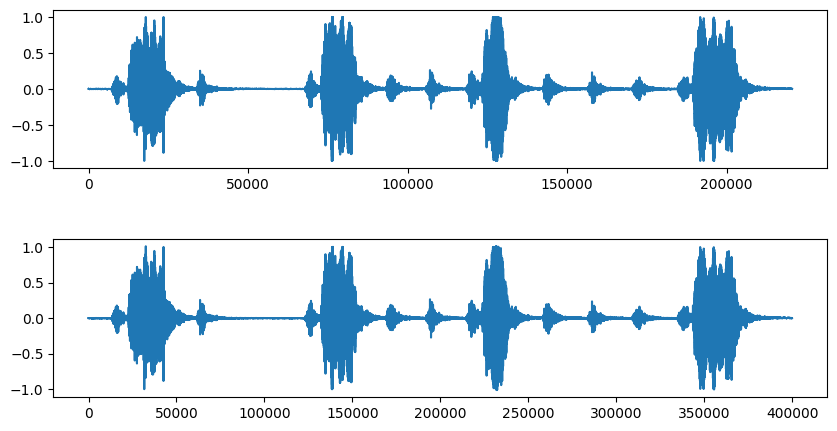

In [16]:
# Load audio using librosa
audio_resample, sample_rate_resample = librosa.load(path1, sr=80000)
print(audio_resample.shape)
print(audio.shape)

display(ipd.Audio(data=audio, rate=sample_rate_resample))
display(ipd.Audio(data=audio_resample, rate=sample_rate_resample))

plt.subplots(2, 1, figsize=(9, 5))
plt.tight_layout(pad=3)


plt.subplot(2, 1, 1)
plt.plot(audio)


plt.subplot(2, 1, 2)
plt.plot(audio_resample)

# Data augmentation for STFT

### Idea

In [17]:
ind = random.randint(0, np.max(np.shape(df_ESC50)))
path1 = df_ESC50.full_path[ind]
audio, sample_rate = librosa.load(path1, sr=44100)
print(f"Category: {df_ESC50.category[ind]}\n")
display(ipd.Audio(data=audio, rate=sample_rate))

Category: sneezing



In [18]:
segment = 20
overlapping = 10
n_fft = segment
nperseg = round(sample_rate * segment / 1000)
noverlap = round(sample_rate * overlapping / 1000)
n_fft = round(sample_rate * n_fft / 1000)
hop_length = nperseg - noverlap

stft_librosa = librosa.stft(
    audio, hop_length=hop_length, win_length=nperseg, n_fft=n_fft
)
r = librosa.amplitude_to_db(np.abs(stft_librosa), ref=np.max)

print(r.shape)

(442, 501)


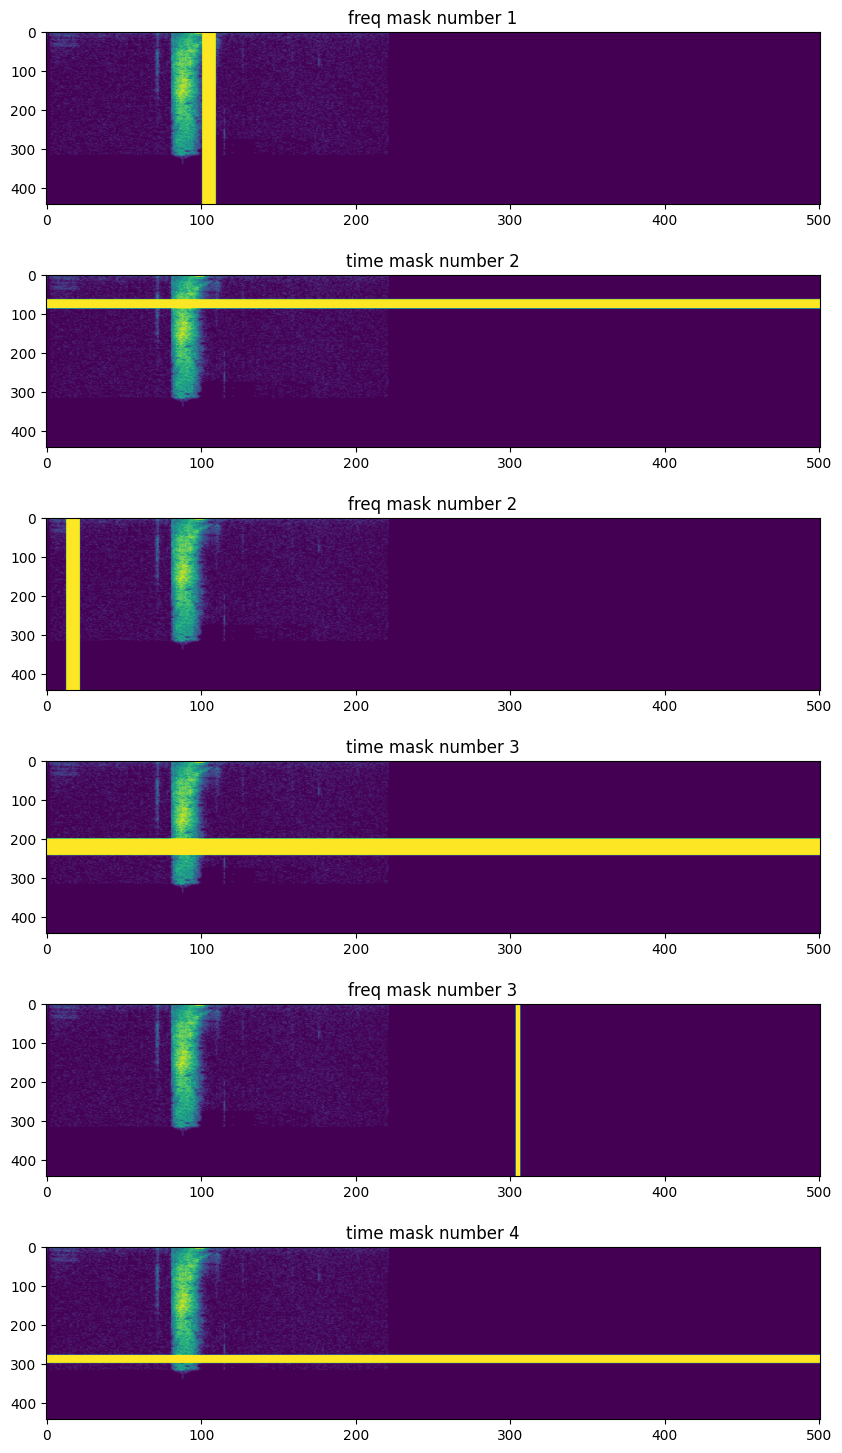

In [19]:
plt.subplots(6, 1, figsize=(9, 15))
plt.tight_layout(pad=3)
for i in range(3):
    # Freq masking
    freq_mask = tfio.audio.freq_mask(r, param=20)

    plt.subplot(6, 1, 2 * i + 1)
    plt.title(f"freq mask number {i+1}")
    plt.imshow(freq_mask.numpy(), aspect="auto")

    # Time masking
    time_mask = tfio.audio.time_mask(r, param=50)

    plt.subplot(6, 1, 2 * i + 2)
    plt.title(f"time mask number {i+2}")
    plt.imshow(time_mask.numpy(), aspect="auto")

### Dataset

In [20]:
batch_size = 30
dataset, label = create_dataset_lite(
    df_ESC50,
    batch_size=batch_size,
    preprocessing="STFT",
    ndim=3,
)

Preprocessing: STFT
The max value is 80.0


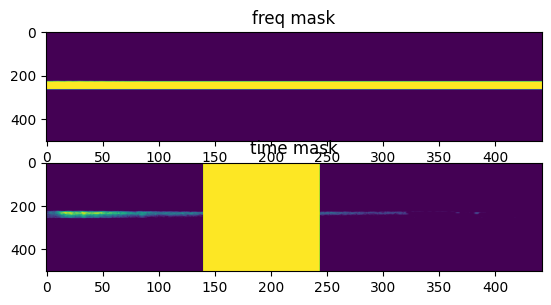

In [21]:
for i, j in dataset.take(1).unbatch():
    i = tf.transpose(i, perm=[1, 0, 2])
    i = tf.squeeze(i, axis=-1)

    # Frequency masking
    freq_mask = tfio.audio.freq_mask(i, param=150)
    freq_mask = tf.transpose(freq_mask, perm=[1, 0])

    plt.subplot(3, 1, 1)
    plt.title(f"freq mask")
    plt.imshow(freq_mask.numpy(), aspect="auto")

    # Time masking
    time_mask = tfio.audio.time_mask(i, param=300)
    time_mask = tf.transpose(time_mask, perm=[1, 0])

    plt.subplot(3, 1, 2)
    plt.title(f"time mask")
    plt.imshow(time_mask.numpy(), aspect="auto")
    broadcast_to_eager_fallback
    break

I want to save every image of the dataset ESC-50 with mask freq and time mask set max to 300

In [22]:
def masking_function(stft, mask, masking_type="time", transpose=True):
    if transpose:
        stft = tf.transpose(stft, perm=[1, 0, 2])
    stft = tf.squeeze(stft, axis=-1)

    if masking_type == "time":
        img_masked = tfio.audio.time_mask(stft, param=mask)
    elif masking_type == "freq":
        img_masked = tfio.audio.freq_mask(stft, param=mask)

    if transpose:
        img_masked = tf.transpose(img_masked, perm=[1, 0])

    img_masked = tf.expand_dims(img_masked, axis=-1)
    return img_masked

In [23]:
freq_mask = 300
time_mask = 300

for i, j in dataset.unbatch().take(2000):
    img_time_masked = masking_function(i, 300, masking_type="time")
    img_freq_masked = masking_function(i, 300, masking_type="freq")

    break  # Remove this line if you want to process more images

In [24]:
# map dataset into masked_dataset
def masking_dataset(dataset, mask, masking_type="time"):
    def masking_function(stft, mask, masking_type="time", transpose=True):
        if transpose:
            stft = tf.transpose(stft, perm=[1, 0, 2])
        stft = tf.squeeze(stft, axis=-1)

        if masking_type == "time":
            img_masked = tfio.audio.time_mask(stft, param=mask)
        elif masking_type == "freq":
            img_masked = tfio.audio.freq_mask(stft, param=mask)

        if transpose:
            img_masked = tf.transpose(img_masked, perm=[1, 0])

        img_masked = tf.expand_dims(img_masked, axis=-1)
        return img_masked

    def masking_function_wrapper(stft, label):
        return masking_function(stft, mask, masking_type=masking_type), label

    return dataset.map(masking_function_wrapper)

In [25]:
freq_mask = 300
time_mask = 300

for k in range(10):  # 1.78 gb per dataset, 35.5 gb in total
    masked_dataset_time = masking_dataset(
        dataset.unbatch(), time_mask, masking_type="time"
    )
    masked_dataset_freq = masking_dataset(
        dataset.unbatch(), freq_mask, masking_type="freq"
    )
    folder = os.path.join(main_dir, "masked_dataset")

    tf.data.Dataset.save(
        masked_dataset_time, os.path.join(folder, "time_mask" + str(k))
    )
    tf.data.Dataset.save(
        masked_dataset_freq, os.path.join(folder, "freq_mask" + str(k))
    )

In [26]:
# load masked dataset
"""import tensorflow as tf
import os
main_dir = os.getcwd()
folder = os.path.join(main_dir, 'Saved_Datasets', 'masked_dataset')
masked_dataset = tf.data.Dataset.load(folder)"""

"import tensorflow as tf\nimport os\nmain_dir = os.getcwd()\nfolder = os.path.join(main_dir, 'Saved_Datasets', 'masked_dataset')\nmasked_dataset = tf.data.Dataset.load(folder)"